---
layout: page
title: Retirement Burndown
---

## How much do I need to retire?

There are two primary components:

- How much are my annual expenses?
- How many years of retirement?

These two components help resolve the original question:

- Will I have enough superannuation fund to cover these expenses during retirement?

In [398]:
import sys
sys.path.insert(0, '../src')
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from IPython.display import display, Markdown

## Retirement Expenses

This data model is based on annual retirement expense data from the [Association of Superannuation Funds of Australia](retirement-planning.md). Expenses are plotted for different 'lifestyle' scenarios:

In [399]:
""" Chart variables """
# annual expenses source retirement-planning.md
# this is also simplified - expenses typically reduce after age 85 when most people have a less active lifestyle.
annual_expenses = {
    "modest": {
        "expenses": 45000,
        "color": "red",
    },
    "comfortable": {
        "expenses": 70000,
        "color": "orange",
    },
    "four-star": {
        "expenses": 90000,
        "color": "green",
    },
    "luxury": {
        "expenses": 140000,
        "color": "blue",
    },
    "opulent": {
        "expenses": 230000,
        "color": "darkviolet",
    },
}

# Create a Markdown table
table = "| Lifestyle | " + " | ".join(key.capitalize() for key in annual_expenses.keys()) + " |\n"
table += "|-----------|" + "|".join("--:" for _ in annual_expenses.keys()) + "|\n"
table += "| Annual    | " + "| ".join("${:,}".format(value['expenses']) for value in annual_expenses.values()) + " |\n"
table += "| Monthly   | " + "| ".join("${:,.0f}".format(round(value['expenses']/12, -2)) for value in annual_expenses.values()) + " |"

# Display the table
display(Markdown(table))

# TODO: add data for singles/couples and different ages

| Lifestyle | Modest | Comfortable | Four-star | Luxury | Opulent |
|-----------|--:|--:|--:|--:|--:|
| Annual    | $45,000| $70,000| $90,000| $140,000| $230,000 |
| Monthly   | $3,800| $5,800| $7,500| $11,700| $19,200 |

In [400]:
life_expectancy = 100
retirement_age = 50 
retirement_years = life_expectancy - retirement_age +1 # add 1 to include year of retirement in range

display(Markdown(f"""
The chart below shows the cumulative retirement expenses for up to {retirement_years - 1} years of retirement:
"""))


The chart below shows the cumulative retirement expenses for up to 50 years of retirement:


In [401]:
""" Data manipulation """

# Create a DataFrame with number of rows = retirement_years
df = pd.DataFrame(index=np.arange(retirement_years))

for i in range(retirement_years):
    df['year'] = retirement_years - df.index -1
    df['age'] = life_expectancy - df.index

# For each key in annual_expenses, create a column
for lifestyle, details in annual_expenses.items():
    # Each year the values increase by the related annual_expenses value
    df[lifestyle.capitalize()] = df.index * details['expenses']
    


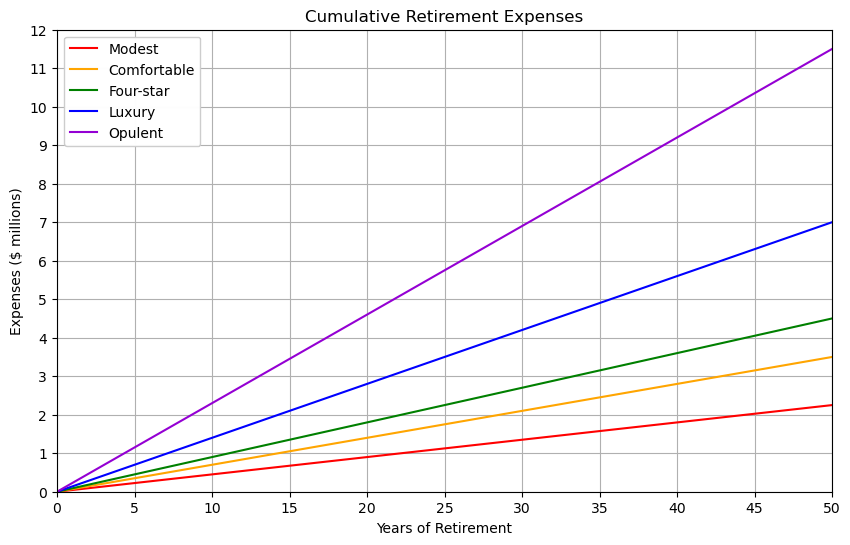

In [402]:
""" Basic chart """
# create a new dataframe with only the annual_expense columns
df_burndown = df[list(key.capitalize() for key in annual_expenses.keys())]

# create a list of colors for each lifestyle
colors = [details['color'] for details in annual_expenses.values()]

# plot the dataframe with the specified colors
df_burndown.plot(figsize=(10, 6), color=colors)

ax = plt.gca()
plt.xlabel('Years of Retirement')
plt.ylabel('Expenses ($ millions)')
plt.title('Cumulative Retirement Expenses')
plt.grid(True)
plt.xlim(0, retirement_years-1)
plt.ylim(ymin=0, ymax=12e6)
# Format x-axis ticks every x years
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
# Format y-axis ticks every 1 million
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e6))
# with labels formatted in millions with no decimal places
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x*1e-6)))
plt.legend().get_frame().set_alpha(0.98)
plt.show()

This model excludes inflation, the true funds required would be much higher as expenses will increase over time. 

Even a modest retirement requires at least a million dollars of expenses. Hopefully superanuation can pay for these expenses.

## Superanuation Returns and Performance

In [403]:
""" Yield Appreciation """

Yield = {
    "bear": 10,
    "base": 20,
    "bull": 40,
}

In [406]:
yield_name = 'bear'

lifestyle = 'comfortable'
expenses = annual_expenses[lifestyle]['expenses'] * -1
yield_rate = Yield[yield_name] / 100

display(Markdown(f"""
Lets start a {yield_name} case with a retirement fund yield or appreciation of {yield_rate * 100}% per year.:
"""))


Lets start a bear case with a retirement fund yield or appreciation of 10.0% per year.:


In [ ]:

columns = ['initial', 'yield', 'eoy', 'expenses', 'balance']
# prefix the lifestyle to each column name
lifestyle_columns = [f'{lifestyle}_{column}' for column in columns]

df_yield = pd.DataFrame(index=np.arange(retirement_years), columns=lifestyle_columns)

for i in range(retirement_years):
    df_yield[f'{lifestyle}_initial'] = df_yield[f'{lifestyle}_eoy'] / (1 + 0.1)
    df_yield[f'{lifestyle}_balance'] = np.where(df.index == 0, 0, df_yield[f'{lifestyle}_initial'].shift())
    df_yield[f'{lifestyle}_expenses'] = expenses
    df_yield[f'{lifestyle}_eoy'] = df_yield[f'{lifestyle}_balance'] - df_yield[f'{lifestyle}_expenses']
    df_yield[f'{lifestyle}_yield'] = df_yield[f'{lifestyle}_initial'] * yield_rate


df_yield.head()

,comfortable_initial,comfortable_yield,comfortable_eoy,comfortable_expenses,comfortable_balance
0,63636.363636,6363.636364,70000,-70000,0
1,121487.603306,12148.760331,133636.363636,-70000,63636.363636
2,174079.639369,17407.963937,191487.603306,-70000,121487.603306
3,221890.581244,22189.058124,244079.639369,-70000,174079.639369
4,265355.073859,26535.507386,291890.581244,-70000,221890.581244


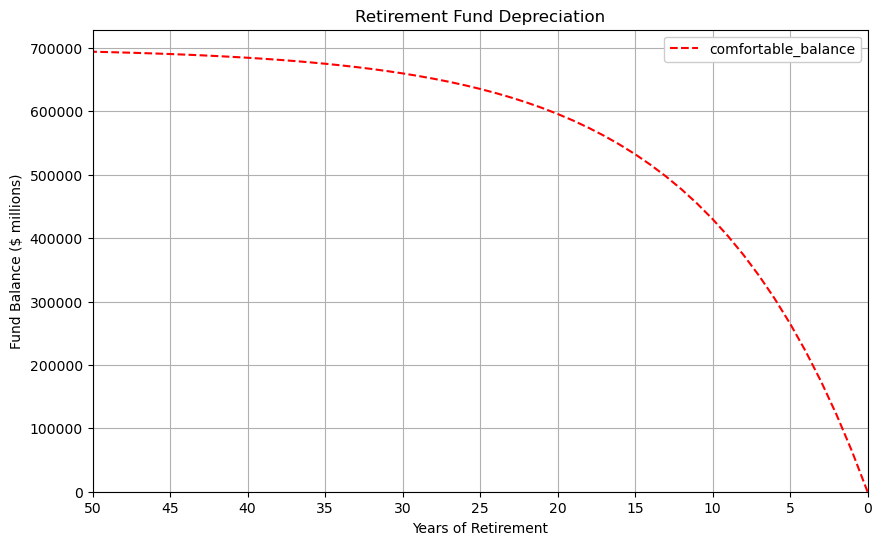

In [ ]:
df_burndown = df_yield[[column for column in df_yield.columns if column.endswith('balance')]]

# create a list of colors for each lifestyle
colors = [details['color'] for details in annual_expenses.values()]
colors = [color for color in colors for _ in range(3)]

# plot the dataframe with the specified colors
df_burndown.plot(figsize=(10, 6), color=colors)

# reverse the x-axis to burndown instead of burnup
ax = plt.gca()
ax.invert_xaxis()

for line in ax.lines:
    # if the line's label contains 'median', set the line style to solid
    if 'median' not in line.get_label():
        line.set_linestyle('--')

plt.xlabel('Years of Retirement')
plt.ylabel('Fund Balance $')
plt.title('Retirement Fund Depreciation')
plt.grid(True)
plt.xlim([retirement_years-1, 0])
plt.ylim(ymin=0) #, ymax=12e6)
# Format x-axis ticks every x years
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
# Format y-axis ticks every 1 million
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e6))
# with labels formatted in millions with no decimal places
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x*1e-6)))
plt.legend().get_frame().set_alpha(0.98)
plt.show()

In [ ]:
# Open the file
with open('../data/inflation_percentiles.md', 'r') as file:
    # Read the file
    inflation_percentiles = file.read()

# Replace headings for percentile column headings
updated_headings_row = '| Years | Lower | Median | Upper |'
inflation_percentile_table = inflation_percentiles.replace(inflation_percentiles.split('\n')[0], updated_headings_row, 1)

# Print the markdown table
print(inflation_percentile_table)

| Years | Lower | Median | Upper |
|-------|-----:|-----:|-----:|
| 1     | 5.85 | 6.50 | 7.20 |
| 10    | 1.50 | 1.90 | 3.00 |
| 30    | 1.70 | 2.40 | 3.12 |



In [ ]:
# No easy python method to convert markdown table to dataframe so reload the file as csv
dfInflation = pd.read_csv('../data/inflation_percentiles.md', sep='|', skipinitialspace=True, skiprows=[1])
# Drop the first and last (empty) columns due to how the markdown table is imported
dfInflation = dfInflation.iloc[:, 1:-1]  
# Remove leading/trailing white spaces from column names
dfInflation.columns = dfInflation.columns.str.strip()
# Remove leading/trailing white spaces from data
dfInflation = dfInflation.map(lambda x: x.strip() if isinstance(x, str) else x)
dfInflation.set_index('Years', inplace=True)

In [ ]:
dfInflation_rate_headings = ['lower', 'median', 'upper']
dfInflation.columns = dfInflation_rate_headings
dfInflation_rate =  dfInflation.iloc[-1]/100
dfInflation_rate.median()

0.024

In [ ]:
""" Inflation adjusted chart """
# multi year inflation from last row
inflation_rate =  dfInflation.iloc[-1]/100

# for each dfInflation_rate column, add a new column to the df dataframe for the inflation adjusted expenses
#for inflation_heading in dfInflation_rate_headings:
#    df[f'comfortable_{inflation_heading}_inflation'] = np.where(df.index == 0, 0, (0 - annual_expenses['comfortable']['expenses']) * (1 + inflation_rate[inflation_heading]) ** (df.index -1) )
#    df[f'comfortable_{inflation_heading}_balance'] = (df[f'comfortable_{inflation_heading}_inflation']*-1).cumsum()

# for each lifestyle in annual_expenses.keys()
for lifestyle in annual_expenses.keys():
    # for each dfInflation_rate column, add a new column to the df dataframe for the inflation adjusted expenses
    for inflation_heading in dfInflation_rate_headings:
        df[f'{lifestyle}_{inflation_heading}_inflation'] = np.where(df.index == 0, 0, (0 - annual_expenses[lifestyle]['expenses']) * (1 + inflation_rate[inflation_heading]) ** (df.index -1) )
        df[f'{lifestyle}_{inflation_heading}_balance'] = (df[f'{lifestyle}_{inflation_heading}_inflation']*-1).cumsum()



In [ ]:
df.head()

,year,age,Modest,Comfortable,Four-star,Luxury,Opulent,modest_lower_inflation,modest_lower_balance,modest_median_inflation,...,luxury_median_inflation,luxury_median_balance,luxury_upper_inflation,luxury_upper_balance,opulent_lower_inflation,opulent_lower_balance,opulent_median_inflation,opulent_median_balance,opulent_upper_inflation,opulent_upper_balance
0,50,100,0,0,0,0,0,0.000000,-0.000000,0.00000,...,0.00000,-0.00000,0.000000,-0.000000,0.00000,-0.00000,0.00000,-0.00000,0.000000,-0.000000
1,49,99,45000,70000,90000,140000,230000,-45000.000000,45000.000000,-45000.00000,...,-140000.00000,140000.00000,-140000.000000,140000.000000,-230000.00000,230000.00000,-230000.00000,230000.00000,-230000.000000,230000.000000
2,48,98,90000,140000,180000,280000,460000,-45765.000000,90765.000000,-46080.00000,...,-143360.00000,283360.00000,-144368.000000,284368.000000,-233910.00000,463910.00000,-235520.00000,465520.00000,-237176.000000,467176.000000
3,47,97,135000,210000,270000,420000,690000,-46543.005000,137308.005000,-47185.92000,...,-146800.64000,430160.64000,-148872.281600,433240.281600,-237886.47000,701796.47000,-241172.48000,706692.48000,-244575.891200,711751.891200
4,46,96,180000,280000,360000,560000,920000,-47334.236085,184642.241085,-48318.38208,...,-150323.85536,580484.49536,-153517.096786,586757.378386,-241930.53999,943727.00999,-246960.61952,953653.09952,-252206.659005,963958.550205


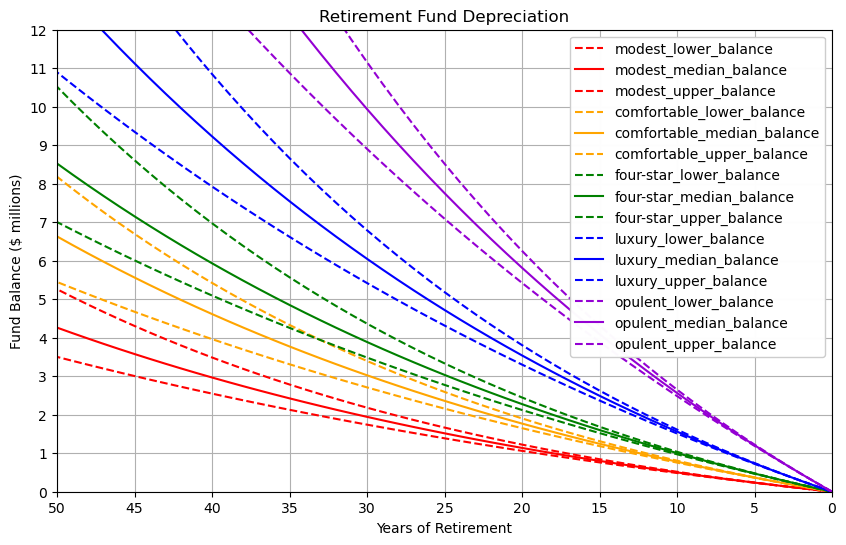

In [ ]:
""" Basic chart """
# create a new dataframe with only the annual_expense columns
#df_burndown = df[list(key+'_balance' for key in annual_expenses.keys())]
#df_burndown = df[list(f'comfortable_{inflation_heading}_balance' for inflation_heading in inflation_rate_headings)]
df_burndown = df[[column for column in df.columns if column.endswith('_balance')]]

# create a list of colors for each lifestyle
colors = [details['color'] for details in annual_expenses.values()]
colors = [color for color in colors for _ in range(3)]

# plot the dataframe with the specified colors
df_burndown.plot(figsize=(10, 6), color=colors)

# reverse the x-axis to burndown instead of burnup
ax = plt.gca()
ax.invert_xaxis()

for line in ax.lines:
    # if the line's label contains 'median', set the line style to solid
    if 'median' not in line.get_label():
        line.set_linestyle('--')

plt.xlabel('Years of Retirement')
plt.ylabel('Fund Balance ($ millions)')
plt.title('Retirement Fund Depreciation')
plt.grid(True)
plt.xlim([retirement_years-1, 0])
plt.ylim(ymin=0, ymax=12e6)
# Format x-axis ticks every x years
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
# Format y-axis ticks every 1 million
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e6))
# with labels formatted in millions with no decimal places
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x*1e-6)))
plt.legend().get_frame().set_alpha(0.98)
plt.show()